# Structural optimization assisted by machine-learning interatomic potentials

In this tutorial, we will show how to perform structural optimization for large structures by using a machine-learning interatomic potential as a surrogate model to reduce the number of potential energy calculation.

## Setting up the simulation

As for MLACS, such simulations contains 3 ingredients
- The system, which consist in an atomic system and it's associated potential
- A minimization method
- A machine-learning interatomic potential

We will start this tutorial by demonstrating the simplest way to set up all these components

### Setting up the system

The first component is the actual system to be simulated.
In this tutorial, we will simulate vacanies in bulk aluminium with a EMT potential

As input, we can use the `bulk` function of the ASE package and remove some atoms.

In [1]:
from ase.build import bulk
at = bulk("Al", cubic=True).repeat(2)  # This create a 2x2x2 supercell of aluminium

# Let's remove random atoms in the structure
import numpy as np
rng = np.random.default_rng()
for _ in range(3):
    at.pop(rng.integers(0, len(at)))

For the potential, we can use the EMT implementation in ASE

In [2]:
from ase.calculators.emt import EMT
calc = EMT()

### Setting up the state

The second ingredient for a MLACS simulation is the state to be sampled.
Usually, the state is defined by the thermostat/barostat used in the molecular dynamics simulation

We will start by setting up some parameters

In [3]:
min_style = 'cg'  # We will use conjugate gradient to minimize
pressure = 0.0  # We will also optimize the cell at 0 pressure
etol = 1e-6  # Energy criterion
ftol = 1e-2  # Forces criterion
stol = 1e-2  # Stress criterion
etol_state = 1e-8  # Energy criterion in the MLIP minimization
ftol_state = 1e-5  # Forces criterion in the MLIP minimization
nsteps = 1000
nsteps_eq = 500

We also have to provide the path to the LAMMPS binary.
This can be set up using a bash command
```bash
export ASE_LAMMPSRUN_COMMAND=~/.local/bin/lmp
```
or directly in python as we will do here

In [4]:
import os
os.environ["ASE_LAMMPSRUN_COMMAND"] = "~/.local/bin/lmp"

Now, we can import the state, that will consist here in a LAMMPS optimizer with the parameters defined earlier.

In [5]:
from mlacs.state import OptimizeLammpsState
state = OptimizeLammpsState(min_style=min_style,
                            pressure=pressure,
                            etol=etol_state,
                            ftol=ftol_state,
                            nsteps=nsteps,
                            nsteps_eq=nsteps_eq)

### Setting up the machine-learning interatomic potential

And the final ingredient is the machine-learning interatomic potential that will drive the molecular dynamics and will be updated from the reference data gathered.

In this example, we will use a SNAP potential with a parameter $2J_{\mathrm{max}}$ of 8.
The setting up of a SNAP potential is done in two steps:
* define the descriptor

In [6]:
from mlacs.mlip import SnapDescriptor
parameters = {"twojmax": 8}
descriptor = SnapDescriptor(at,
                            parameters=parameters)

* Define the model

To improve on the convergence, we will train our potential so that it's getting better and better as we get closer to the minima.
To do this, we will apply some weights for the configurations, in order to give more importance to the configurations close to the minima and less to the one far from it.
This can be done by using a `WeightingPolicy` object which gives more importance to the last configurations added to the dataset.
We will use weights given by $i^{10}$ where i is the index of the simulation in the dataset (starting at i=1).

In [7]:
from mlacs.mlip import LinearPotential, IncreasingWeight
power = 10
energy_coefficient = 1e-5
forces_coefficient = 1
stress_coefficient = 10
weight = IncreasingWeight(power=10,
                          energy_coefficient=energy_coefficient,
                          forces_coefficient=forces_coefficient,
                          stress_coefficient=stress_coefficient)
mlip = LinearPotential(descriptor, weight=weight)

## Gathering everything and launching the simulation

Now that everything is set up, we can gather everything into a `MlMinimizer` object

In [8]:
from mlacs import MlMinimizer
dyn = MlMinimizer(at,
                  state,
                  calc,
                  mlip,
                  etol=etol,
                  ftol=ftol,
                  stol=stol)

    On-the-fly Machine-Learning Assisted Canonical Sampling
======================= version  0.0.13 =====================
date: 25-03-2024  08:35:28


State 1/1 :
Geometry optimization as implemented in LAMMPS


True potential parameters:
Calculator : emt
parameters :


Linear potential
Parameters:
-----------
Fit method :            ols

Descriptor used in the potential:
SNAP descriptor
---------------
Elements :
Al
Parameters :
rcut                5.0
chemflag            0
twojmax             8
rfac0               0.99363
rmin0               0.0
switchflag          1
bzeroflag           1
wselfallflag        0
dimension           56




and launch the simulation for 20 steps

In [9]:
dyn.run(20)

Step 0
Running initial step
There are 1 unique configuration in the states 
Computation done, creating trajectories

Computing energy with true potential on training configurations

Step 1

Equilibration step for state 1, configuration 1 for this state


Training new MLIP


Number of configurations for training: 2
Number of atomic environments for training: 58

Using Increasing weighting
Weighted RMSE Energy    0.0001 eV/at
Weighted MAE Energy     0.0001 eV/at
Weighted RMSE Forces    0.0015 eV/angs
Weighted MAE Forces     0.0011 eV/angs
Weighted RMSE Stress    0.0003 GPa
Weighted MAE Stress     0.0002 GPa

Running MLMD
State 1/1 has been launched
Computing energy with the True potential

Energy difference : 0.084482 eV/at
Maximum absolute force : 0.028523 eV/angs
Maximum stress tensor difference : 0.23441 GPa

Step 2

Equilibration step for state 1, configuration 2 for this state


Training new MLIP


Number of configurations for training: 3
Number of atomic environments for training: 

And that's it !

The simulations, computed with the reference potential, can be found in the `Trajectory.traj` file

In [10]:
from ase.io import read
confs = read("Trajectory.traj", index=":")

And we can plot for example the energy along the trajectory to observe that we reach the minimum

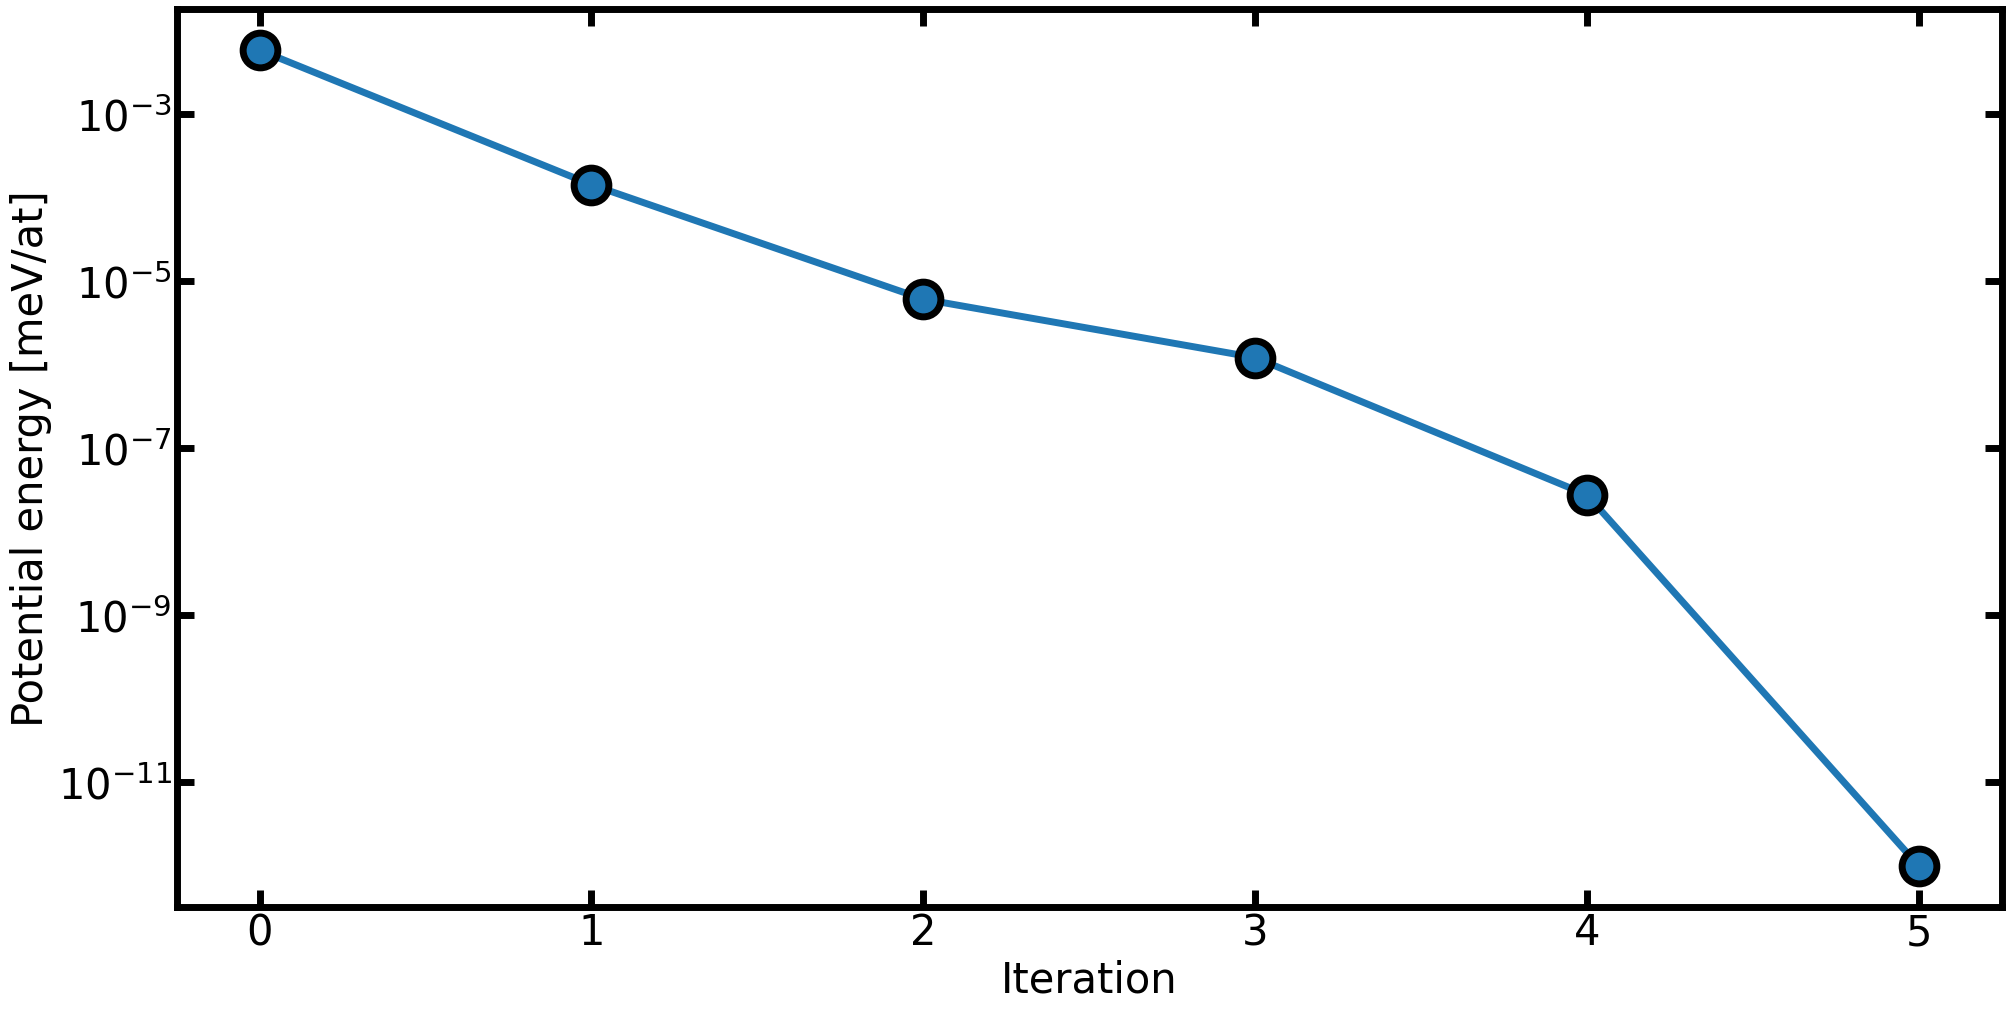

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mlacs.utilities.plots import init_rcParams

x = np.arange(len(confs))
energies = np.array([a.get_potential_energy() / len(a) for a in confs])

fig = plt.figure(figsize=(20, 10), constrained_layout=True)
init_rcParams()
ax0 = fig.add_subplot()
ax0.set_xlabel("Iteration")
ax0.set_ylabel("Potential energy [meV/at]")
ax0.plot(x, energies - energies.min() + 1e-12, marker="o")
ax0.set_yscale("log")
plt.show()